In [72]:
# Try the averaging up/down profiles technique/filtering out the rotation period for averaging purposes



from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_spec_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
big_uncertainty_store = []
big_loc_store = []
resid_store = np.array([])

#For investigating down profiles
#down_min_z = []
#up_min_z =[]


up = True

float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2 , 59))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 2))
    loc_store = np.zeros((len(efr_files), 2))
    prof_store = np.zeros(len(efr_files), dtype=object)
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        
        #Uncomment this to print out the filenames where EM starts before CTD
        #if len(moving_inds)<len(Pef):
            #print(len(Pef)-len(moving_inds), fname)
            #continue
            
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef_moving = Pef[moving_inds]
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);
            resid = np.nanmean(resid,1);

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit

        ## Do spike detection
        #If either channel has spikes, ignore the profile.
        spikes=contains_spikes(E1, E2)
        if spikes:
            #print(fname)
            continue
        
        
        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        

        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)


        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

        E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
        E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
        
        
    
        ##Get the mean residual level below 90m for the purpose of estimating error
        deep_inds = np.where(Pef_moving>=90)
        error = np.sqrt(np.square(e1r[deep_inds])+np.square(e2r[deep_inds]))
        resid_store = np.append(resid_store, error)
        
        
        #Now take the spectra
        nblock = 120
        fs = 1
        overlap = 60
        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            continue
        
      
        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)
        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])

        time_s = -1*(mlt_efr - mlt_efr[0])
        rad_per_s = np.gradient(avg_angs, time_s) #radians per second. rotation period is 2pi/rad_per_s
        Rotp = 2*np.pi/rad_per_s
        
        [Rotp_reshaped, _] = reshape_u(Rotp, Pef, nblock, overlap, fs)
        
        zero_inds = np.where(prof_speed==0)[0]
        #if len(zero_inds)>0:
            #print(z_x[0, :])
            
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)

        VVwindow, fwindow = make_vel_spectrum(u_y, fs)

        min_z = np.min(Pef)
            
        #if min_z>20:
        #    too_deep_counter+=1
        #else:  
        min_bin = np.append(min_bin, min_z)
        first_bot = np.append(first_bot, z_x[0, -1])

        UU = UUwindow/(int(nblock/2)*fs)
        Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
        VV = VVwindow/(int(nblock/2)*fs)
        Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

        Eh = Exx+Eyy


        [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
        u_noise = 0 #This is just for testing...
        [lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)

        #Average each profile spec and add to the storer
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            spec_store[counter, 0, :] = np.nanmean(Eh, axis=0)
            spec_store[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)

            time_store[counter] = np.nanmean(mlt_efr)
            prof_store[counter] = prof_num

            uncertainty_store[counter, :] = np.array([lbound, ubound])
            loc_store[counter, :] = np.array([avg_lat, avg_lon])
            if prof_num%2==0:
                #Then it's even and its an up profile
                up_down_store[counter] = 1
            else:
                up_down_store[counter] = 0

        
        
            counter+=1
        
        
    
    # Now store each one in a big array for sorting etc later
    if float_id_counter==0:
        big_spec_store=spec_store
        big_uncertainty_store = uncertainty_store
        big_time_store = time_store
        big_up_down_store = up_down_store
        big_prof_store = prof_store
        big_loc_store = loc_store
    else:
        big_spec_store = np.append(big_spec_store, spec_store, axis=0)
        big_uncertainty_store = np.append(big_uncertainty_store,uncertainty_store, axis=0)
        big_time_store = np.append(big_time_store, time_store)
        big_up_down_store = np.append(big_up_down_store, up_down_store)
        big_prof_store = np.append(big_prof_store, prof_store)
        big_loc_store = np.append(big_loc_store, loc_store, axis=0)


    
    float_id_counter+=1
        
    #np.save(save_dir+float_id, spec_store)

In [78]:
out = zip(prof_store, spec_store, time_store)
sorted_array = sorted(out, key=lambda tup: tup[0])

unzipped = ([ a for a,b,c in sorted_array ], [ b for a,b,c in sorted_array ], [c for a,b,c in sorted_array])
prof_store_sorted = np.array(unzipped[0])
spec_store_sorted = np.array(unzipped[1])
time_store_sorted = np.array(unzipped[2])

#kill everything with prof_store=0 bc that's fake

#Need to sort better...

In [90]:
spec_store_duo = np.zeros((len(prof_store)//2, 2 , 59))
prof_store_duo = np.zeros((len(prof_store)//2, 2))


pair_counter = 0
for n in range(0,len(spec_store_duo)):
    if prof_store_sorted[2*n]+1 == prof_store_sorted[2*n+1]:
        spec_store_duo[pair_counter, 0, :]=spec_store_sorted[n, 1, :]
        spec_store_duo[pair_counter, 1, :]=spec_store_sorted[n+1, 1, :]
        prof_store_duo[pair_counter, 0] = prof_store_sorted[n]
        prof_store_duo[pair_counter, 1] = prof_store_sorted[n+1]


        
        pair_counter+=1

In [91]:
mean_spec = np.zeros((len(spec_store_duo), len(fwindow[1:])))
for pair in range(spec_store_duo.shape[0]):
    mean_spec[pair] = np.nanmean(np.array([spec_store_duo[pair, 0, :], spec_store_duo[pair, 1, :]]),axis=0)

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_8039/1701750792.py:3: RuntimeWarning: Mean of empty slice
  mean_spec[pair] = np.nanmean(np.array([spec_store_duo[pair, 0, :], spec_store_duo[pair, 1, :]]),axis=0)


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_8039/3498142844.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.loglog(fwindow[1:], mean_spec[ind3], 'k', LineWidth=4, label='EM-APEX Mean')


21.0
22.0


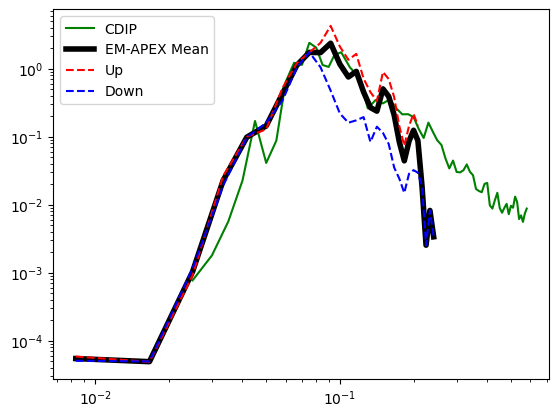

In [108]:
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
ind3 =1
ind= 2*ind3
nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = [datetime.datetime.fromtimestamp(t) for t in times]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])

ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP", color='g')
plt.loglog(fwindow[1:], mean_spec[ind3], 'k', LineWidth=4, label='EM-APEX Mean')
plt.loglog(fwindow[1:], spec_store_duo[ind3, 0, :], '--r', label='Up')
plt.loglog(fwindow[1:], spec_store_duo[ind3, 1, :], '--b', label='Down')
plt.legend()
print(prof_store_duo[2, 0])
print(prof_store_duo[2, 1])




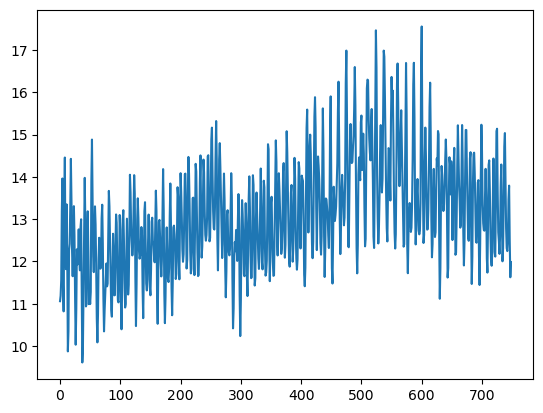

In [21]:
plt.plot(Rotp)

In [23]:
Rotp_reshaped.shape

(11, 120)

In [34]:
window_rotp = np.nanmean(Rotp_reshaped, axis=1)
window_rotp_std = np.nanstd(Rotp_reshaped, axis=1)
llim = 1/(window_rotp+window_rotp_std)
ulim = 1/(window_rotp-window_rotp_std)
window_rotf = 1/window_rotp 

In [35]:
window_rotf

array([0.08292869, 0.08257911, 0.07981453, 0.07773715, 0.07793403,
       0.07713698, 0.07444575, 0.07096456, 0.07001155, 0.07213646,
       0.07388359])

In [36]:
llim

array([0.07618204, 0.07678378, 0.07420121, 0.07194885, 0.07207011,
       0.07154038, 0.06851323, 0.06475508, 0.06396305, 0.06605092,
       0.06829457])

In [37]:
ulim

array([0.0909864 , 0.08932067, 0.08634664, 0.08453827, 0.08483667,
       0.08368353, 0.08150306, 0.07849122, 0.07732343, 0.07945717,
       0.08046894])

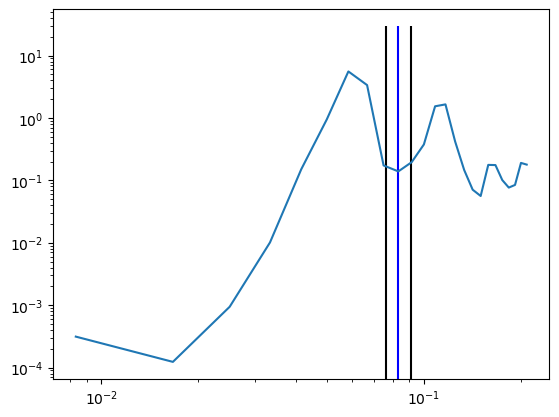

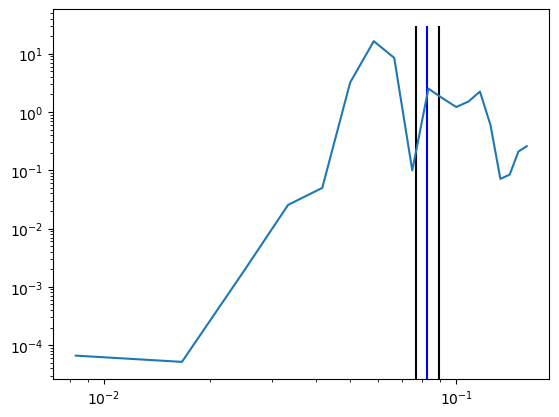

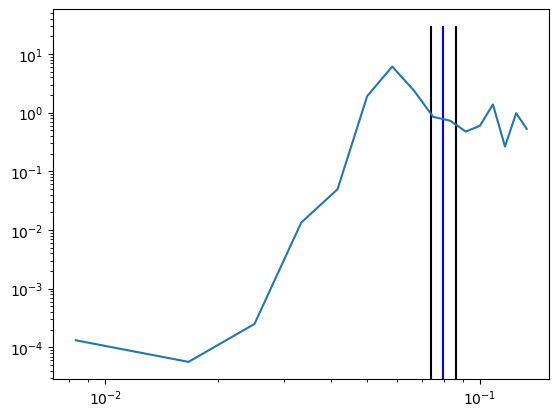

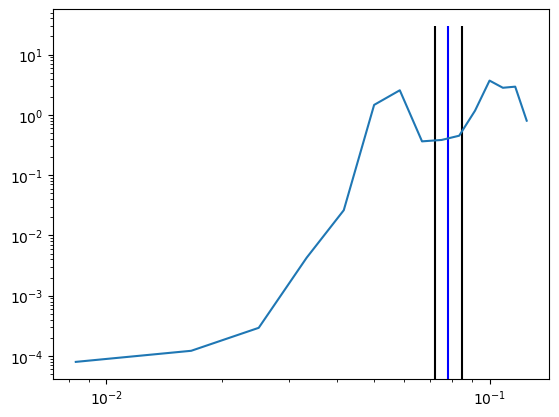

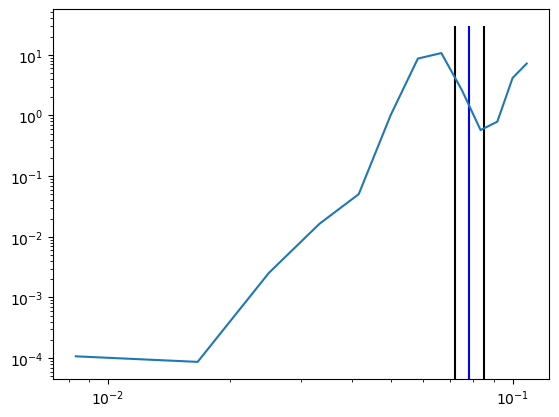

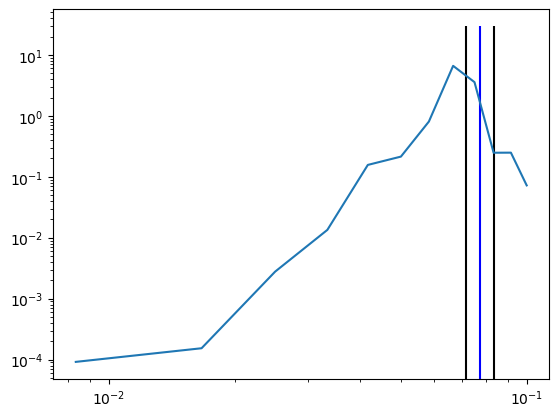

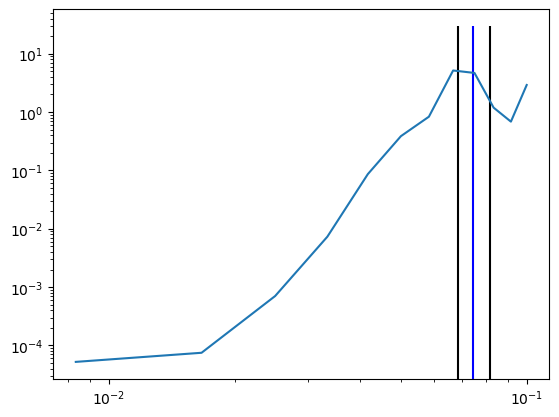

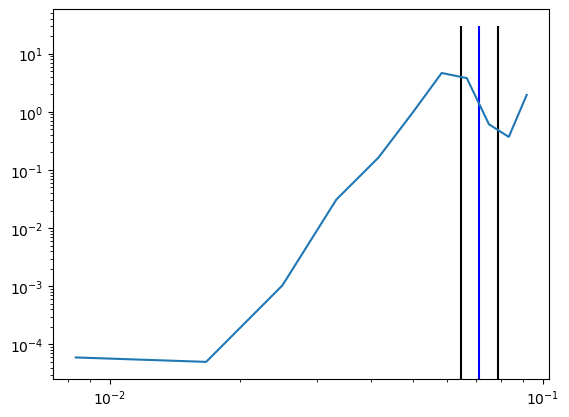

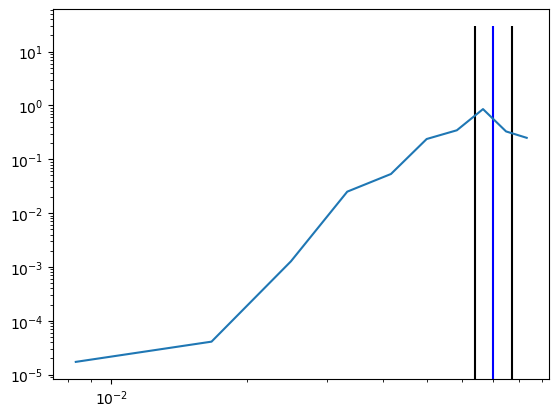

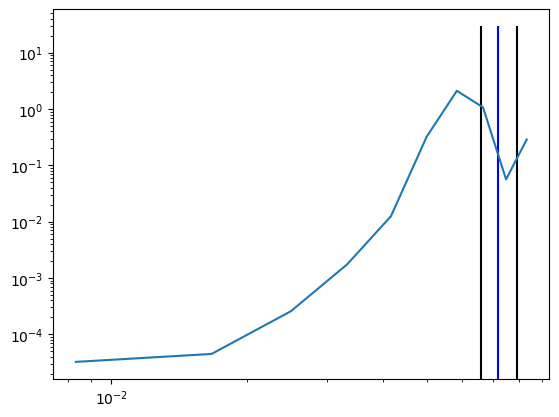

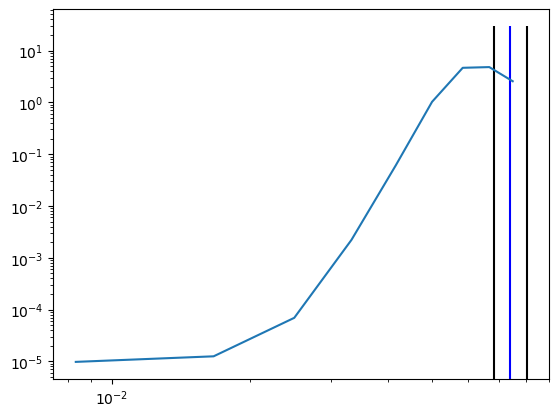

In [49]:
### Plotting impact of rotation period on spectra

n_windows = Eh_Eric4.shape[0]
for n in range(n_windows):
    plt.figure()
    plt.loglog(fwindow[1:], np.transpose(Eh_Eric4[n, :]))
    plt.vlines(x=llim[n], ymin=0, ymax=30, color='k')
    plt.vlines(x=ulim[n], ymin=0, ymax=30, color='k')
    plt.vlines(x=window_rotf[n], ymin=0, ymax=30, color='b')